# Preprosesing


In [20]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [21]:
train_dir = r"C:\Users\M S I\Documents\BANGKIT\train"
test_dir = r"C:\Users\M S I\Documents\BANGKIT\test"

In [22]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for name in dirs:
            class_dir = os.path.join(root, name)
            num_files = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[name] = num_files
    return class_counts

In [23]:
# Hitung jumlah gambar per kelas di set pelatihan dan uji
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

In [24]:
# Buat DataFrame untuk visualisasi
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

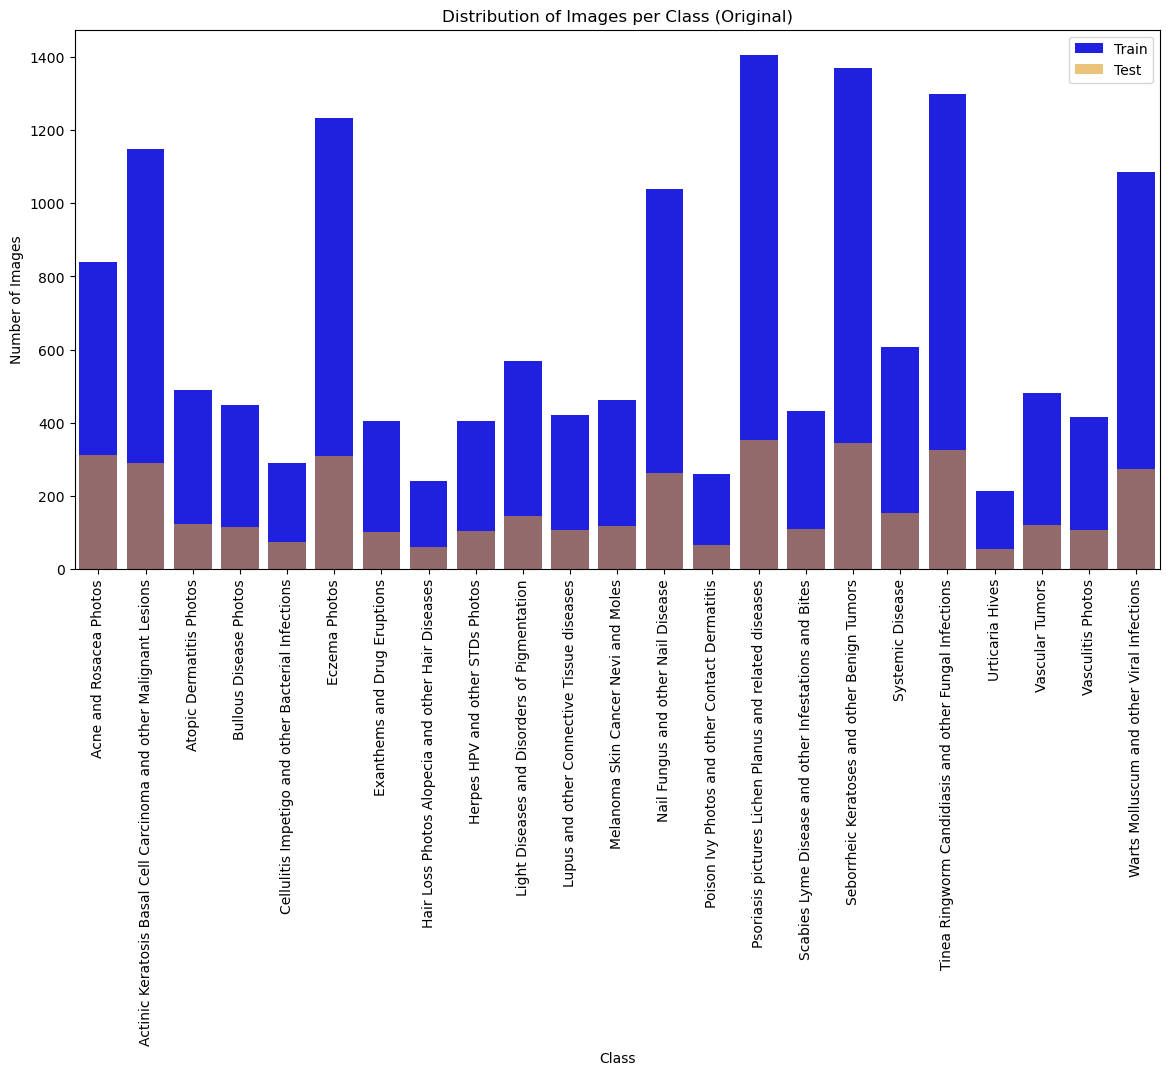

In [25]:
# Visualisasi distribusi gambar awal
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Count', data=df_train, color='blue', label='Train')
sns.barplot(x='Class', y='Count', data=df_test, color='orange', label='Test', alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class (Original)')
plt.legend()
plt.show()

In [26]:
# Filter kelas yang memiliki lebih dari 1000 gambar
filtered_classes = [cls for cls, count in train_counts.items() if count > 1000]


In [27]:
# Path ke direktori baru untuk data yang telah difilter
filtered_train_dir = r"C:\Users\M S I\Documents\BANGKIT\train_filtered"
filtered_test_dir = r"C:\Users\M S I\Documents\BANGKIT\test_filtered"

In [28]:
# Buat direktori baru jika belum ada
if not os.path.exists(filtered_train_dir):
    os.makedirs(filtered_train_dir)

if not os.path.exists(filtered_test_dir):
    os.makedirs(filtered_test_dir)

In [29]:
# Salin gambar dari kelas yang dipilih ke direktori baru (train)
for cls in filtered_classes:
    src_class_dir = os.path.join(train_dir, cls)
    dst_class_dir = os.path.join(filtered_train_dir, cls)
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
    
    for file_name in os.listdir(src_class_dir):
        full_file_name = os.path.join(src_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst_class_dir)

# Salin gambar dari kelas yang dipilih ke direktori baru (test)
for cls in filtered_classes:
    src_class_dir = os.path.join(test_dir, cls)
    dst_class_dir = os.path.join(filtered_test_dir, cls)
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
    
    for file_name in os.listdir(src_class_dir):
        full_file_name = os.path.join(src_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst_class_dir)

In [30]:
# Hasil akhir: kelas dengan >1000 gambar ada di filtered_train_dir dan filtered_test_dir
print(f"Kelas yang memiliki lebih dari 1000 gambar: {filtered_classes}")

Kelas yang memiliki lebih dari 1000 gambar: ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Eczema Photos', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


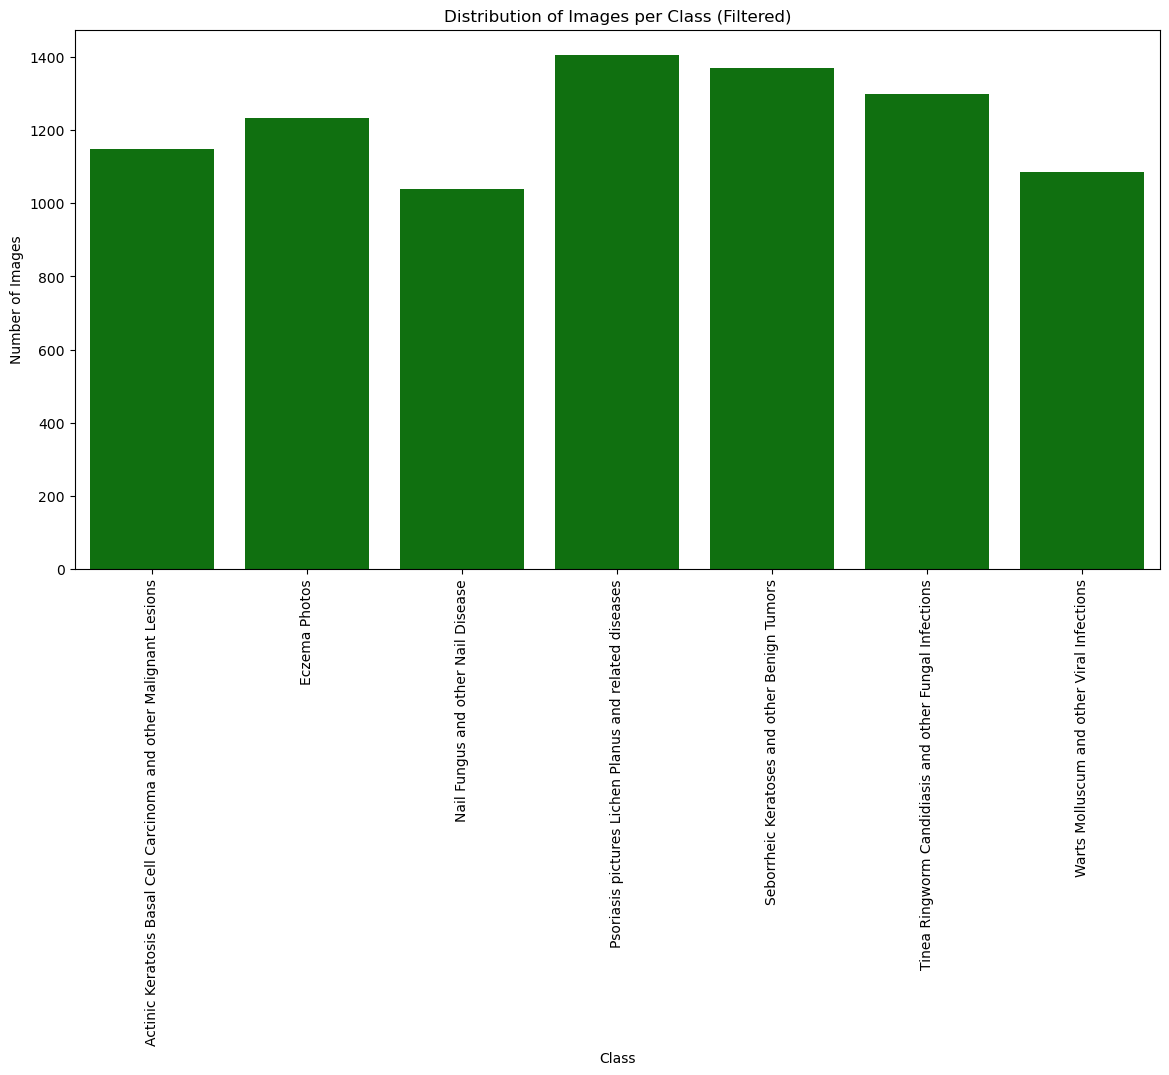

In [31]:
# Visualisasi distribusi gambar setelah filtering
filtered_train_counts = count_images_per_class(filtered_train_dir)
df_filtered_train = pd.DataFrame(list(filtered_train_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Count', data=df_filtered_train, color='green')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class (Filtered)')
plt.show()

# Data Augmentation

In [32]:
# ImageDataGenerator untuk augmentasi dan normalisasi data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load dan preprocess filtered training data
train_generator = train_datagen.flow_from_directory(
    filtered_train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load dan preprocess filtered testing data
test_generator = test_datagen.flow_from_directory(
    filtered_test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 8586 images belonging to 7 classes.
Found 2150 images belonging to 7 classes.


# Model Transfer Learning DenseNet121

In [33]:
# Load DenseNet121 model pretrained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add new layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Steps per epoch untuk pelatihan
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, test_generator.samples // test_generator.batch_size)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50


C:\Users\M S I\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.2258 - loss: 2.2325 - val_accuracy: 0.3815 - val_loss: 1.5986 - learning_rate: 1.0000e-04
Epoch 2/50
  1/268 ━━━━━━━━━━━━━━━━━━━━ 2:46 624ms/step - accuracy: 0.3125 - loss: 1.5557

C:\Users\M S I\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 1.5557 - val_accuracy: 0.3333 - val_loss: 1.4888 - learning_rate: 1.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.3557 - loss: 1.6836 - val_accuracy: 0.4216 - val_loss: 1.5205 - learning_rate: 1.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3750 - loss: 1.7044 - val_accuracy: 0.5000 - val_loss: 1.5393 - learning_rate: 1.0000e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.3796 - loss: 1.6026 - val_accuracy: 0.4422 - val_loss: 1.4855 - learning_rate: 1.0000e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.5033 - val_accuracy: 0.1667 - val_loss: 1.6189 - learning_rate: 1.0000e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 266s 984ms/step - accuracy: 0.4081 - loss: 1.5247 - val_accuracy: 0.4552 - val_loss: 1.4602 - learning_rate: 1.0000e-04
Epoch 8/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.375

# Fine-Tuning Model

In [34]:
#Unfreeze semua lapisan base_model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 1089s 4s/step - accuracy: 0.3627 - loss: 1.6535 - val_accuracy: 0.4650 - val_loss: 1.4455 - learning_rate: 1.0000e-05
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5625 - loss: 1.2319 - val_accuracy: 0.3333 - val_loss: 1.9526 - learning_rate: 1.0000e-05
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 979s 4s/step - accuracy: 0.4308 - loss: 1.4681 - val_accuracy: 0.4762 - val_loss: 1.4051 - learning_rate: 1.0000e-05
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4688 - loss: 1.2796 - val_accuracy: 0.5000 - val_loss: 1.5185 - learning_rate: 1.0000e-05
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.4802 - loss: 1.3786 - val_accuracy: 0.4897 - val_loss: 1.3721 - learning_rate: 1.0000e-05
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4688 - loss: 1.5850 - val_accuracy: 0.3333 - val_loss: 1.7387 - learning_rate: 1.0000e-05
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 949s 4s/step - accur

In [35]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')

# Save the final model
best_model.save('cnn_skin_disease_classifier_final.keras')


In [36]:
# Plot kinerja model
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy ({title})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss ({title})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

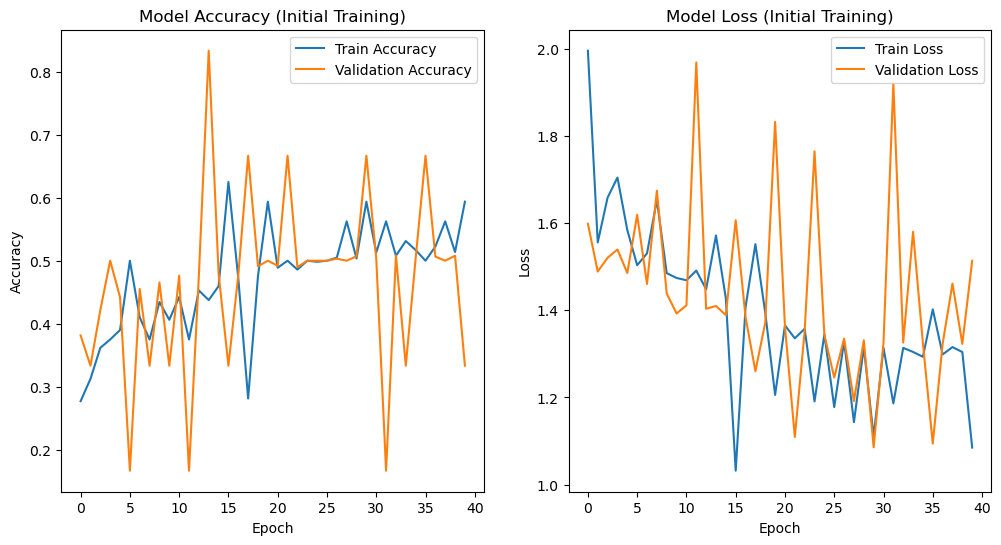

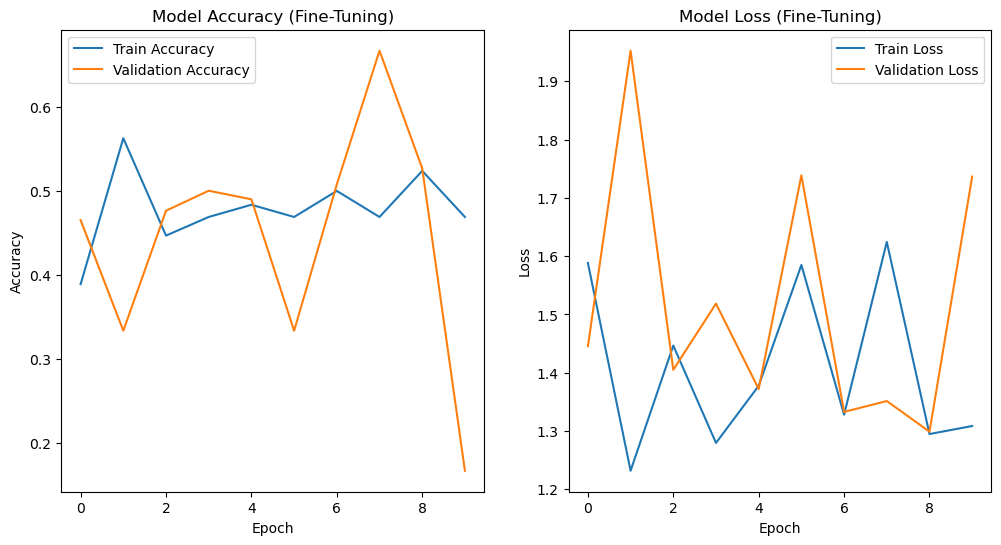

In [37]:
# Plot history
plot_history(history, 'Initial Training')
plot_history(history_fine_tune, 'Fine-Tuning')